In [9]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from plot_params import * 
from scipy.stats import normaltest, shapiro
from scipy import integrate


In [97]:
def task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))
        
def short_task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request(priority=processing_time) as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))
        
def batch_mean(x, batch_size):
    x_mean = np.reshape(x,(batch_size,int(len(x)/batch_size)))
    x_mean = np.mean(x_mean, axis=0)
    return x_mean

def batch_var(x, batch_size, n_batches, n_samples):
    mean_x = np.mean(x)
    batch_var = batch_size/(n_samples*(n_batches-1))*np.square(x - mean_x).sum()
    return batch_var

def deterministic(x):
    return 1/x

def longtail(x):
    mu_big = 1
    mu_small = 0.75*x*mu_big/(mu_big-0.25*x)
    a = random.random()
    if a < 0.25:
        n = random.expovariate(mu_big)
    else:
        n = random.expovariate(mu_small)
    return n


def MMn(rho, mu, n):
    def Pi_w(n, rho):
        def B(n, rho):
            B = 1
            for i in range(1, n + 1):
                B = rho * B / (i + rho * B)
            return B
        b = B(n - 1, n * rho)
        return rho * b / (1 - rho + rho * b)
    pi_w = Pi_w(n, rho)
    return pi_w / (n * mu) / (1 - rho)


def MDn(rho, mu, n):
    return rho ** n / np.math.factorial(n) / (1 - rho) / 2 / mu / n 

def longtail_pred(rho, mu, n):
    return rho ** n / np.math.factorial(n) / (1 - rho)  / mu / n * 1.05125

def SPTF(rho, mu, n, upp=100):
    if n > 1: 
        return None
    def integrand(x):
        return rho * np.exp(-x * mu) / (1 - (1 - np.exp(-x * mu) * (1 + x * mu)) * rho) ** 2
    I = integrate.quad(integrand, 0, upp)
    return I[0]

In [11]:
class Setup_samples(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, n_samples, p_distribution):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.n_samples_reached = env.event()
        self.n_samples = n_samples
        self.p_distribution = p_distribution
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>self.n_samples:
                self.n_samples_reached.succeed()
                self.n_samples_reached = self.env.event()
            
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)
            processing_time = self.p_distribution(self.processing_capacity)
            env.process(task(self.env, self.server, processing_time, waiting_times))

class Setup_shortestjob(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, n_samples, p_distribution):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.n_samples_reached = env.event()
        self.n_samples = n_samples
        self.p_distribution = p_distribution
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>self.n_samples:
                self.n_samples_reached.succeed()
                self.n_samples_reached = self.env.event()
            
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)
            processing_time = self.p_distribution(self.processing_capacity)
            env.process(short_task(self.env, self.server, processing_time, waiting_times))

In [12]:
#global variables
n_steps = 10
n_servers = np.array([1, 2, 4])
arrival_rate = n_servers
init_util = 0.5
final_util = 0.9
server_util = np.linspace(init_util, final_util, n_steps)
processing_capacity = 1/server_util
n_samples = 5000
waiting_times_rho_mm = np.zeros((3, n_steps,n_samples))
waiting_times_rho_md = np.zeros((3, n_steps,n_samples))
waiting_times_rho_l = np.zeros((3, n_steps,n_samples))
waiting_times_rho_s = np.zeros((3, n_steps,n_samples))

In [13]:
# #for mm/1 and mm/n
# for i in range(3):
#     for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
#         env = simpy.Environment()
#         servers1 = simpy.Resource(env, capacity=n_servers[i])
#         waiting_times = []
#         setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,random.expovariate)
#         env.run(until=setup1.n_samples_reached)
#         waiting_times_rho_mm[i, j, :] = setup1.waiting_times[:n_samples] 
# np.save(f'results/waiting_times_rho_mm', waiting_times_rho_mm)

calculate waiting times for n_server 4: 100%|██████████| 10/10 [00:00<00:00, 10.29it/s]


In [14]:
# #for md/1 and md/n
# for i in range(3):
#     for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
#         env = simpy.Environment()
#         servers1 = simpy.Resource(env, capacity=n_servers[i])
#         waiting_times = []
#         setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,deterministic)
#         env.run(until=setup1.n_samples_reached)
#         waiting_times_rho_md[i, j, :] = setup1.waiting_times[:n_samples]
# np.save(f'results/waiting_times_rho_md', waiting_times_rho_md)

calculate waiting times for n_server 4: 100%|██████████| 10/10 [00:00<00:00, 10.54it/s]


In [15]:
# #for longtail
# for i in range(3):
#     for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
#         env = simpy.Environment()
#         servers1 = simpy.Resource(env, capacity=n_servers[i])
#         waiting_times = []
#         setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,longtail)
#         env.run(until=setup1.n_samples_reached)
#         waiting_times_rho_l[i, j, :] = setup1.waiting_times[:n_samples]
# np.save(f'results/waiting_times_rho_l', waiting_times_rho_l)

calculate waiting times for n_server 4: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


In [16]:
# #for shortest job first
# for i in range(3):
#     for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
#         env = simpy.Environment()
#         servers1 = simpy.PriorityResource(env, capacity=n_servers[i])
#         waiting_times = []
#         setup1 = Setup_shortestjob(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,random.expovariate)
#         env.run(until=setup1.n_samples_reached)
#         waiting_times_rho_s[i, j, :] = setup1.waiting_times[:n_samples]
# np.save(f'results/waiting_times_rho_s', waiting_times_rho_s)

calculate waiting times for n_server 4: 100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


In [101]:
#load the results of the simulation
path_to_results = 'D:\School\Stochastic simulation\Results-DES'
path_to_results = '../DES_results'
waiting_times_rho_mm = np.load(path_to_results + '\waiting_times_rho_mm.npy')
waiting_times_rho_md = np.load(path_to_results + '\waiting_times_rho_md.npy')
waiting_times_rho_l = np.load(path_to_results + '\waiting_times_rho_l.npy')
waiting_times_rho_s = np.load(path_to_results + '\waiting_times_rho_s.npy')

In [102]:
#batch_size = np.linspace(1000,50000, n_steps)
#batch_size = np.array([1000, 6000, 12000, 10000, 22800, 30000, 33700, 40000, 34000, 50000,])*2
batch_size = 333333
#batch_size -= batch_size % -100
#batch_size = batch_size * 2 
n_batches = 15
n_samples = n_batches*batch_size
#n_samples_normal = batch_size*n_batches
batch_means = np.zeros((3, n_batches,n_steps))

mean_waiting_time_mm = np.zeros((3,n_steps))
var_waiting_time_mm = np.zeros((3,n_steps))

mean_waiting_time_md = np.zeros((3,n_steps))
var_waiting_time_md = np.zeros((3,n_steps))

mean_waiting_time_l = np.zeros((3,n_steps))
var_waiting_time_l = np.zeros((3,n_steps))

mean_waiting_time_s = np.zeros((3,n_steps))
var_waiting_time_s = np.zeros((3,n_steps))

all_results = [waiting_times_rho_mm, waiting_times_rho_md, waiting_times_rho_l, waiting_times_rho_s]
all_results_mean = [mean_waiting_time_mm,mean_waiting_time_md,mean_waiting_time_l,mean_waiting_time_s]
all_results_var = [var_waiting_time_mm,var_waiting_time_md,var_waiting_time_l,var_waiting_time_s]

for means, var, waiting_times in zip(all_results_mean, all_results_var, all_results):
    for i in range(3):
        # for ax, j in zip(axs, range(n_steps)):
        for j in range(n_steps):
            batch_means[i,:,j] = batch_mean(waiting_times[i,j,:n_samples], batch_size)
            stat, p = shapiro(batch_means[i,:,j])
            if p > 0.05:
                print(f'{j} is normal distributed with p={p}')
            else:
                print(f'{j} is NOT normal distributed with p={p}')
            means[i,j] = np.mean(batch_means[i,:,j])
            var[i,j] = batch_var(batch_means[i,:,j], batch_size, n_batches, n_samples)
    

0 is normal distributed with p=0.29980984330177307
1 is normal distributed with p=0.8208455443382263
2 is normal distributed with p=0.5274419188499451
3 is normal distributed with p=0.43671026825904846
4 is normal distributed with p=0.6352049112319946
5 is normal distributed with p=0.8962748646736145
6 is normal distributed with p=0.4022328853607178
7 is normal distributed with p=0.5207313895225525
8 is normal distributed with p=0.8320700526237488
9 is normal distributed with p=0.6315590143203735
0 is normal distributed with p=0.16746851801872253
1 is normal distributed with p=0.7590300440788269
2 is normal distributed with p=0.3488152325153351
3 is normal distributed with p=0.9990302324295044
4 is normal distributed with p=0.43001413345336914
5 is normal distributed with p=0.8107196092605591
6 is normal distributed with p=0.31779202818870544
7 is normal distributed with p=0.6551013588905334
8 is normal distributed with p=0.8390267491340637
9 is normal distributed with p=0.132273629307

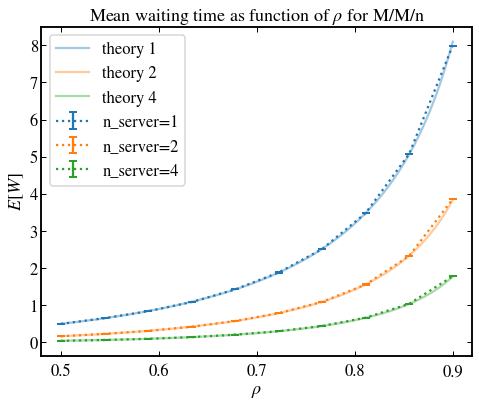

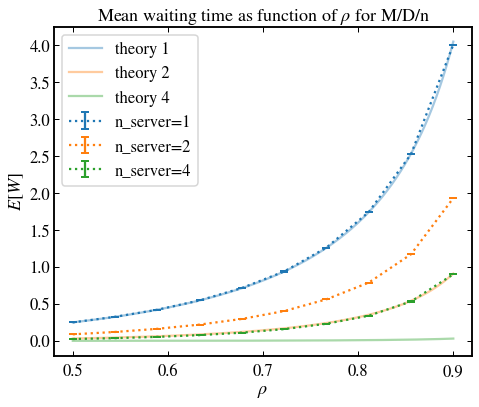

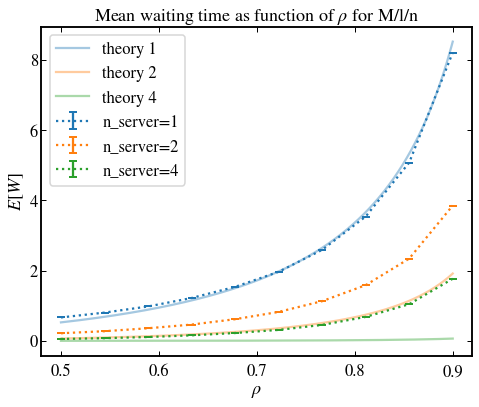

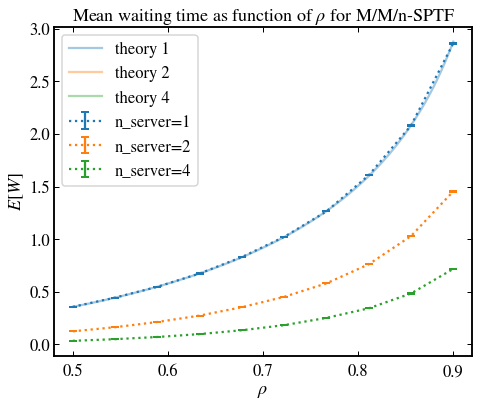

In [103]:
theory_functions = [MMn, MDn, longtail_pred, SPTF]
rho_range = np.linspace(init_util, final_util, 1000)
mu_range = 1 / rho_range
queue_name = ['M/M/n', 'M/D/n', 'M/l/n', 'M/M/n-SPTF']
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for mean, var, name, func in zip(all_results_mean, all_results_var, queue_name, theory_functions):
    plt.figure()
    for i in range(3):
        plt.errorbar(
            server_util, 
            mean[i,:], np.sqrt(var[i,:]), 
            fmt=':', 
            capsize=4, 
            capthick=2, 
            label=f'n_server={n_servers[i]}',
            color=colors[i]
        )
        plt.fill_between(server_util, mean[i,:] - np.sqrt(var[i,:]), mean[i,:] + np.sqrt(var[i,:]), alpha=0.2)
        # theory plot
        y_theory = [func(rho, mu, n_servers[i]) for rho, mu in zip(rho_range, mu_range)]
        plt.plot(rho_range, y_theory, label=f'theory {n_servers[i]}', color=colors[i], alpha=0.4)

    plt.legend() 
    plt.title((r'Mean waiting time as function of $\rho$ for ' + name))
    plt.xlabel(r'$\rho$')
    plt.ylabel('$E[W]$')
    plt.tight_layout()
    #plt.savefig('figures/area_conv_s.pdf')
    plt.show()      